In [1]:
# from missingno import missingno
import requests
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.cluster import hierarchy
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
def download_file(url, filename):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return filename

In [4]:
if not os.path.isfile("NYPD Motor Vehicle Collisions.csv"):
    dat = download_file("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD",
                        "NYPD Motor Vehicle Collisions.csv")
dat = pd.read_csv("NYPD Motor Vehicle Collisions.csv", index_col=23)

In [5]:
# TODO: Implement sorting.

def _ascending_sort(df):
    """
    Helper method for sorting.
    Returns a DataFrame whose values have been rearranged by ascending completeness.
    """
    return df.iloc[np.argsort(df.count(axis='columns').values), :]

def _descending_sort(df):
    """
    Helper method for sorting.
    Returns a DataFrame whose values have been rearranged by descending completeness.
    """
    return df.iloc[np.flipud(np.argsort(df.count(axis='columns').values)), :]

def missingno_sort(df, sort=None):
    """
    Conglomerate method for sorting a DataFrame.
    Calls on the above functions to achieve its purpose.
    """
    _df = df
    if sort == "ascending":
        _df = _ascending_sort(df)
    elif sort == "descending":
        _df = _descending_sort(df)
    return _df

In [6]:
def _n_top_complete_filter(df, n):
    """
    Helper method for filtering a DataFrame.
    Returns the top n most populated entry columns.
    """
    return df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[-n:])]


def _n_bottom_complete_filter(df, n):
    """
    Helper method for filtering a DataFrame.
    Returns the bottom n least populated entry columns.
    """
    return df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values))[:n]]

def _p_top_complete_filter(df, p):
    """
    Helper method for filtering a DataFrame.
    Returns the entry columns which are at least p*100 percent completeness.
    """
    return df.iloc[:, [c >= p for c in df.count(axis='rows').values / len(df)]]

def _p_bottom_complete_filter(df, p):
    """
    Helper method for filtering a DataFrame.
    Returns the entry columns which are at most p*100 percent completeness.
    """
    return df.iloc[:, [c <= p for c in df.count(axis='rows').values / len(df)]]

def missingno_filter(df, filter=None, p=0, n=0):
    """
    Conglomerate method for filtering a DataFrame.
    Calls on the above functions to achieve its purpose.
    """
    _df = df
    if filter == "top":
        if p:
            _df = _p_top_complete_filter(_df, p)
        if n:
            _df = _n_top_complete_filter(_df, n)
    elif filter == "bottom":
        if p:
            _df = _p_bottom_complete_filter(_df, p)
        if n:
            _df = _n_bottom_complete_filter(_df, n)
    return _df

In [17]:
def _set_profile_font_size(fig, df, fontsize):
    """
    Guesses an appropriate fontsize for the given columnar visualization text labels.
    Used if a fontsize is not provided via a parameter.
    """
    if fontsize:
        return fontsize
    else:
        return int((fig.get_size_inches()[1] * 0.8)*fig.dpi / len(df.columns) - 5)
    
def _set_dendogram_font_size(fig, df, fontsize):
    """
    Guesses an appropriate fontsize for the given dendogram visualization text labels.
    Used if a fontsize is not provided via a parameter.
    """
    if fontsize:
        return fontsize
    else:
        return int((fig.get_size_inches()[1] * 0.8)*fig.dpi / len(df.columns) - 4)

In [8]:
def profile(df,
            filter=None, n=0, p=0,
            sort=None,
            figsize=(20, 10), width_ratios=(15, 1), color=(0.25, 0.25, 0.25),
            fontsize=0, labels=True, sparkline=True, inline=True
           ):
    
    # Apply filters and sorts.
    df = missingno_filter(df, filter=filter, n=n, p=p)
    df = missingno_sort(df, sort=sort)
    
    height = df.shape[0]
    width = df.shape[1]
    
    # Z is the color-mask array.
    Z = df.notnull().values
        
    # G is a NxNx3 matrix
    G = np.zeros((height, width, 3))

    # Apply the Z color-mask to set the RGB of each pixel.
    G[Z < 0.5] = [1, 1, 1]
    G[Z > 0.5] = color

    # Set up the matplotlib grid layout.
    fig = plt.figure(figsize=figsize)
    if sparkline:
        gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)
        gs.update(wspace=0.08)
        ax1 = plt.subplot(gs[1])
    else:
        gs = gridspec.GridSpec(1, 1)
    ax0 = plt.subplot(gs[0])
    # Create the nullity plot.
    ax0.imshow(G, interpolation='none')

    # Set fontsize.
    fontsize = _set_profile_font_size(fig, df, fontsize)
    
    # Remove extraneous default visual elements.
    ax0.set_aspect('auto')
    ax0.grid(b=False)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position('none')
    ax0.yaxis.set_ticks_position('none')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)

    # Set up and rotate the column ticks.
    if labels:
        ha = 'left'
        ax0.set_xticks(list(range(0, width)))
        ax0.set_xticklabels(list(df.columns), rotation=45, ha=ha, fontsize=fontsize)
    else:
        ax0.set_xticks([])

    # Set up the two top-bottom row ticks.
    ax0.set_yticks([0, df.shape[0] - 1])
    ax0.set_yticklabels([1, df.shape[0]], fontsize=20)
    # Create the inter-column vertical grid.
    in_between_point = [x + 0.5 for x in range(0, width - 1)]
    for in_between_point in in_between_point:
        ax0.axvline(in_between_point, linestyle='-', color='white')

    if sparkline:
        # Calculate row-wise completeness for the sparkline.
        completeness_srs = df.notnull().astype(bool).sum(axis=1)
        x_domain = list(range(0, height))
        y_range = list(reversed(completeness_srs.values))
        min_completeness = min(y_range)
        max_completeness = max(y_range)
        min_completeness_index = y_range.index(min_completeness)
        max_completeness_index = y_range.index(max_completeness)

        # Set up the sparkline.
        ax1.grid(b=False)
        ax1.set_aspect('auto')
        ax1.set_axis_bgcolor((1, 1, 1))
        # Remove the black border.
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['left'].set_visible(False)

        # Plot sparkline---plot is sideways so the x and y axis are reversed.
        ax1.plot(y_range, x_domain, color=color)

        if labels:
            # Figure out what case to display the label in: mixed, upper, lower.
            label = 'Data Completeness'
            if df.columns[0].islower():
                label = label.lower()
            if df.columns[0].isupper():
                label = label.upper()

            # Set up and rotate the sparkline label.
            ha = 'left'
            ax1.set_xticks([min_completeness + (max_completeness - min_completeness) / 2])
            ax1.set_xticklabels([label], rotation=45, ha=ha, fontsize=fontsize)
            ax1.xaxis.tick_top()
            ax1.set_yticks([])
        else:
            ax1.set_xticks([])
            ax1.set_yticks([])

        # Add maximum and minimum labels.
        ax1.annotate(max_completeness,
                     xy=(max_completeness, max_completeness_index),
                     xytext=(max_completeness + 2, max_completeness_index),
                     fontsize=14,
                     va='center',
                     ha='left')
        ax1.annotate(min_completeness,
                     xy=(min_completeness, min_completeness_index),
                     xytext=(min_completeness - 2, min_completeness_index),
                     fontsize=14,
                     va='center',
                     ha='right')

        # Add maximum and minimum circles.
        ax1.set_xlim([min_completeness - 2, max_completeness + 2])  # Otherwise the circles are cut off.
        ax1.plot([min_completeness], [min_completeness_index], '.', color=color, markersize=10.0)
        ax1.plot([max_completeness], [max_completeness_index], '.', color=color, markersize=10.0)

        # Remove tick mark (only works after plotting).
        ax1.xaxis.set_ticks_position('none')
        
    if inline:
        plt.show()
    else:
        return fig.axes

0 False 17


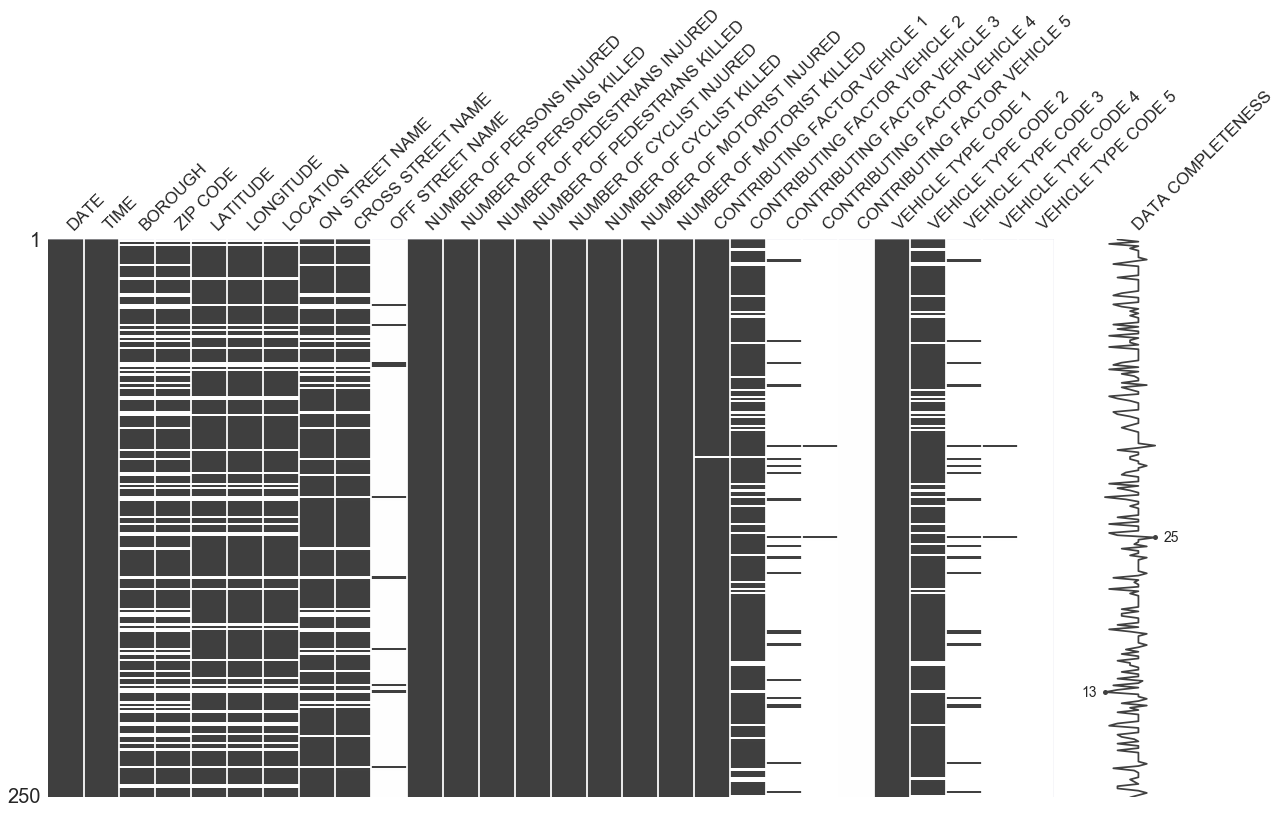

In [9]:
profile(dat.sample(250))

In [10]:
def heatmap(df, inline=True,
            filter=None, n=0, p=0, sort=None,
            figsize=(20, 12), color=(0.25, 0.25, 0.25),
            fontsize=16, labels=True, cmap='RdBu'
           ):

    # Apply filters and sorts.
    df = missingno_filter(df, filter=filter, n=n, p=p)
    df = missingno_sort(df, sort=sort)
    
    # Set up the figure.
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 1)
    ax0 = plt.subplot(gs[0])
    
    # Create and mask the correlation matrix.
    corr_mat = df.isnull().corr()
    corr_mat[np.isnan(corr_mat)] = 0
    mask = np.zeros_like(corr_mat)
    mask[np.triu_indices_from(mask)] = True
    
    # Construct the base heatmap.
    if labels:
        sns.heatmap(corr_mat, mask=mask, cmap=cmap, ax=ax0, cbar=False, annot=True, fmt='.1f')
    else:
        sns.heatmap(corr_mat, mask=mask, cmap=cmap, ax=ax0, cbar=False)        

    # Set fontsize.
    fontsize = _set_dendogram_font_size(df, fig, )
        
    # Apply visual corrections and modifications.
    ax0.set_xticklabels(ax0.xaxis.get_majorticklabels(), rotation=45, ha='left', fontsize=fontsize)
    ax0.set_yticklabels(ax0.yaxis.get_majorticklabels(), fontsize=fontsize)

    ax0.xaxis.tick_top()
    ax0.patch.set_visible(False)

    # Plot if inline, return axes if not.
    if inline:
        plt.show()
    else:
        return fig.axes

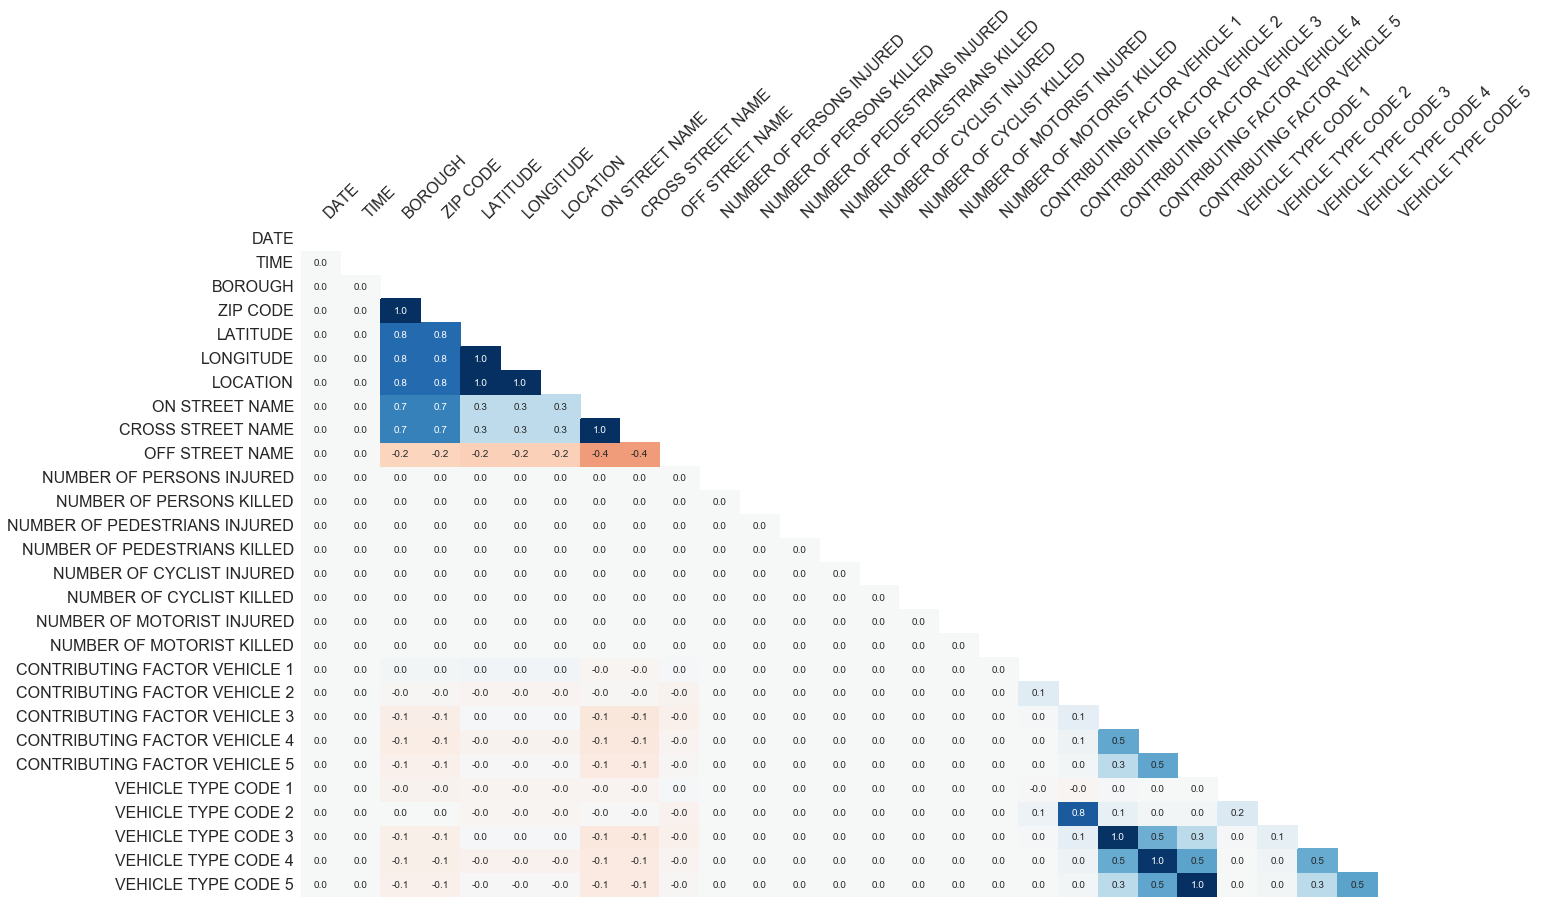

In [11]:
heatmap(dat.sample(1000))

In [15]:
def dendogram(df, inline=True,
              filter=None, n=0, p=0, sort=None,
              fontsize=0, labels=True, cmap='RdBu'
             ):

    # Set up the figure.
    fig = plt.figure(figsize=(25, 10))
    gs = gridspec.GridSpec(1, 1)
    ax0 = plt.subplot(gs[0])
        
    # Apply filters and sorts.
    df = missingno_filter(df, filter=filter, n=n, p=p)
    df = missingno_sort(df, sort=sort)
    
    # Set font size.
    fontsize = _set_dendogram_font_size(fig, df, fontsize)
    
    # Link the heirarchical output matrix.
    X = np.transpose(df.isnull().astype(int).values)
    Z = hierarchy.linkage(X, 'average')

    # Construct the base dendogram.    
    ret = hierarchy.dendrogram(Z,
                               orientation='bottom',
                               labels=dat.columns.tolist(),
                               distance_sort='descending',
                               link_color_func=lambda x: 'black',
                               leaf_font_size=fontsize,
                               ax=ax0
                              )

    # Remove extraneous default visual elements.
    ax0.set_aspect('auto')
    ax0.grid(b=False)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position('none')
    ax0.yaxis.set_ticks_position('none')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    ax0.patch.set_visible(False)

    # Set up the categorical axis labels.
    ax0.set_xticklabels(ax0.xaxis.get_majorticklabels(), rotation=45, ha='left')

    # Set up the distance axis labels.
    # First fetch the maximum distance.
    max_dist = np.max(hierarchy.maxdists(Z))
    # Use that to place percentage markers.
    ax0.set_yticks(np.linspace(0, np.max(hierarchy.maxdists(Z)), 6))
    ax0.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # Plot if inline, return axes if not.
    if inline:
        plt.show()
    else:
        return fig.axes

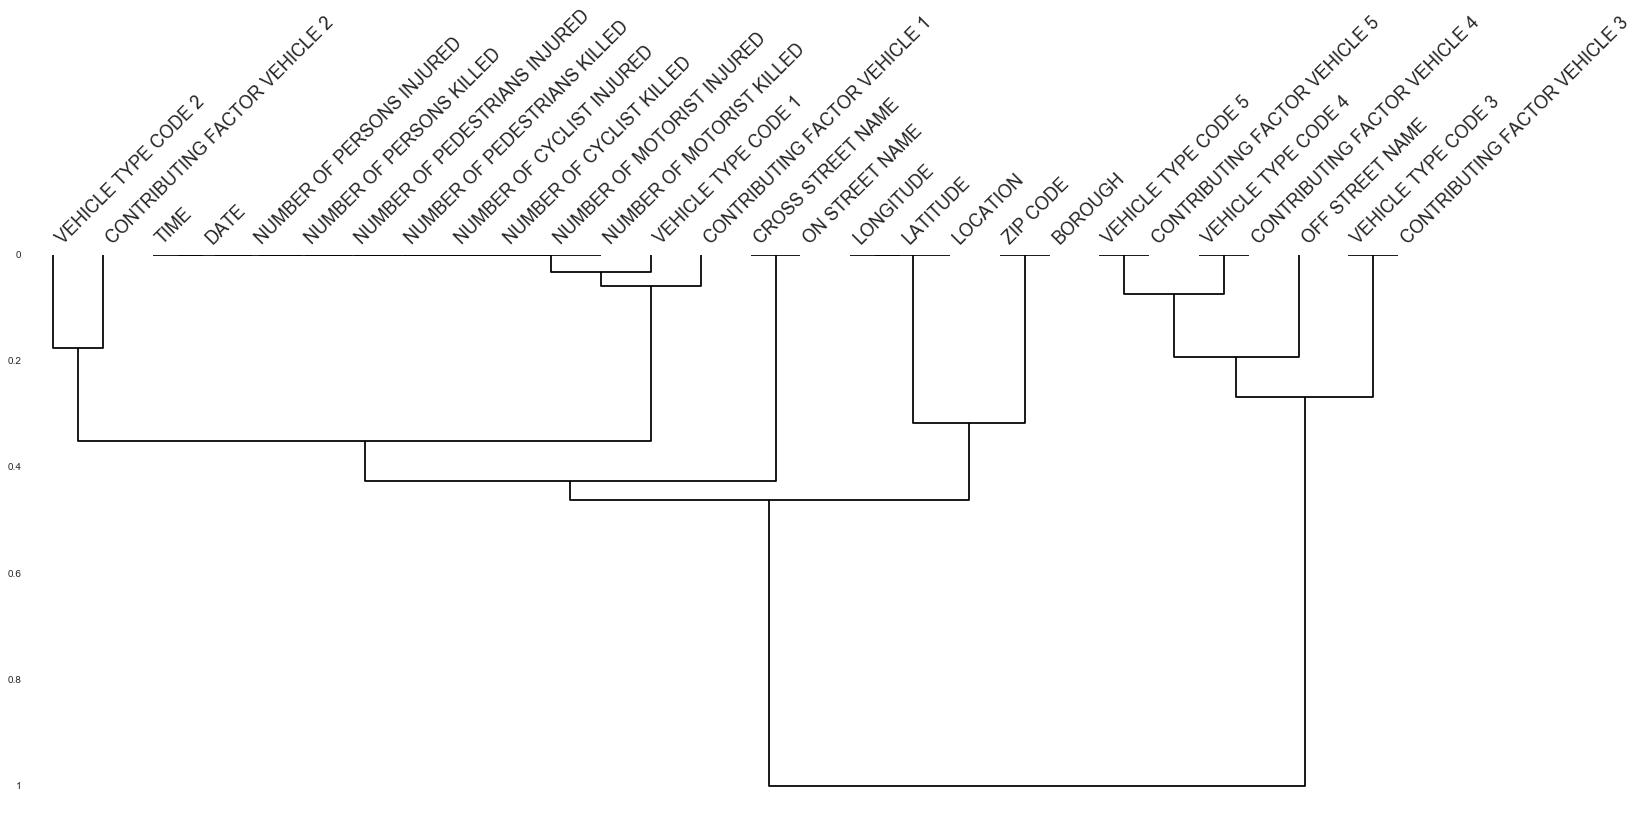

In [18]:
dendogram(dat.sample(1000))